Machinery for manufacturing LIBS type spectra

TODO: class docstrings AND Type Hints per:
https://realpython.com/documenting-python-code/
https://docs.python.org/3/library/typing.html

In [3]:
#imports and env
import math
import pickle

import numpy as np

from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt

#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker import spectrum_maker
from pathlib import Path

top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path
datafile = "rel_int/valid77_spec.pickle"

<function matplotlib.pyplot.show(close=None, block=None)>

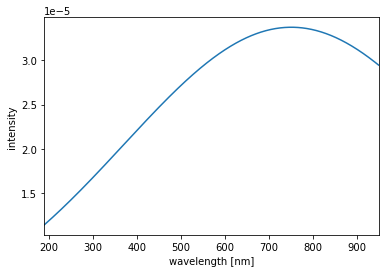

In [4]:
#explore Gaussian artifact formula
inc=1
w_lo=190 # lower limit of spectrum
w_hi=950 # upper limit of spectrum
maximum=0.1 #max relative intensity
sigma = (w_hi-w_lo) * 0.5
mu = np.random.randint(w_lo,w_hi)
wave = np.arange(w_lo,w_hi,inc)
bg = 100 * np.random.rand() * maximum * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
plt.plot(wave, bg)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


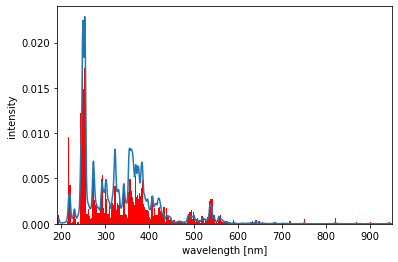

In [19]:
#Test peak maker method from class spectrum_maker
my_maker = spectrum_maker(1)
wave, spec = my_maker.peak_maker(element = "Fe", plot = True, voigt_gam=1)
print(type(wave))
print(type(spec))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(close=None, block=None)>

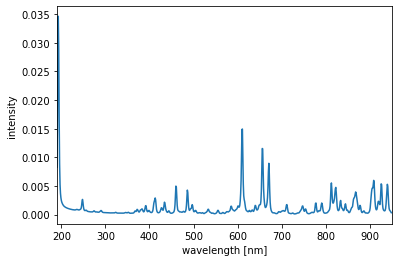

In [17]:
#Test method make_spectra from class spectrum_maker
my_maker = spectrum_maker(10)
#first 10 elements
my_elem = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']
my_fracs = [0.1, 0, 0.2, 0, 0, 0.3, 0.2, 0.1, 0, 0.1]
my_wave, my_spec, my_specarray = my_maker.make_spectra(fracs=my_fracs)
print(type(my_wave), type(my_spec), type(my_specarray))

plt.plot(my_wave, my_spec)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

In [20]:
#test batch_spectra method
my_maker = spectrum_maker(20)
fracs, wave, x_data, y_data = my_maker.batch_spectra()
#confirm we recover the composite spectrum from the truncated aggregation of elements+art+noise
math.isclose(np.max(abs(np.where(np.sum(y_data[0], axis=0) < 0, 0, np.sum(y_data[0], axis=0)) - x_data[0])),0)

True

In [295]:
#generate and persist large data set for model training and validation
#Note: 10,000 samples with default settings (no mods, artifacts, noise) took 6m4s or ~27/sec
#Expect 1 million to require ~10 hours which is fine since not recurring task
#However, the 10k data set takes up 1.4Gb on disk when pickled, 250Mb when compressed
#May be smart to use cloud storage 4.*
# for this, AWS S3 or GCP and read the data in from there for training model variants
my_maker = spectrum_maker(77)
fracs, wave, x_data, y_data = my_maker.batch_spectra(batch=10000, n_elem=1, n_delta=0, noise=False, snr=10**8)

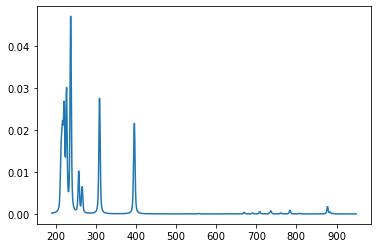

In [296]:
plt.plot(wave, x_data[0])

In [297]:
#persist sample data and provide code to reload elsewhere
# better ways? https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
#1M records compressed might only be ~25Gb on disk, but probably break into many files to limit RAM footprint while processing
with open(datapath / 'training' / 'single_els_10k', 'wb') as f:
   pickle.dump(fracs, f)
   pickle.dump(wave, f)
   pickle.dump(x_data, f)
   pickle.dump(y_data, f)

#To load in other modules
#with open(datapath / 'my_file', 'rb') as f:
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#    y_data = pickle.load(f)